Author: Leonardo Chiarioni  
email: leonardo.chiarioni@studio.unibo.it

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

import numpy as np
from matplotlib import pyplot as plt

# Blind source separation

This project aims to separate an image, formed as the sum of two images, into its original components.

The two source images, img1 and img2, are drawn from different datasets: MNIST and Fashion-MNIST, respectively.

No preprocessing is allowed. The neural network receives the combined image (img1 + img2) as input and outputs the predicted components (hat_img1,hat_img2).

Performance is evaluated using the mean squared error (MSE) between the predicted and ground-truth images.

Both datasets (MNIST and Fashion-MNIST) are grayscale. For simplicity, all samples are padded to a (32,32) resolution.

## Dataset
The dataset consists of low-resolution grey-scale images (32,32) obtained by averaging pairs of images from mnist and fashion mnist dataset. Each of the training dataset contains $60000$ images, which implies $60000^2$ different possible images. That said, is very hard for our model to overfit the dataset. For this specific reason, we define a very small validation set to test our models during training.

In [ ]:
val_size = 0.1
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
mnist_x_train, mnist_x_val, mnist_y_train, mnist_y_val = train_test_split(mnist_x_train, mnist_y_train, test_size=val_size)
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
fashion_mnist_x_train, fashion_mnist_x_val, fashion_mnist_y_train, fashion_mnist_y_val = train_test_split(fashion_mnist_x_train, fashion_mnist_y_train, test_size=val_size)

#normalize and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_val = np.pad(mnist_x_val,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_val = np.pad(fashion_mnist_x_val,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.


print(f"mnist train size: {np.shape(mnist_x_train)}")
print(f"fashion_mnist train size: {np.shape(fashion_mnist_x_train)}")
print(f"mnist val size: {np.shape(mnist_x_val)}")
print(f"fashion_mnist val size: {np.shape(fashion_mnist_x_val)}")
print(f"mnist test size: {np.shape(mnist_x_test)}")
print(f"fashion_mnist test size: {np.shape(fashion_mnist_x_test)}")

mnist train size: (54000, 32, 32)
fashion_mnist train size: (54000, 32, 32)
mnist val size: (6000, 32, 32)
fashion_mnist val size: (6000, 32, 32)
mnist test size: (10000, 32, 32)
fashion_mnist test size: (10000, 32, 32)


The dataset is provided through a generator:

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Let us look at some input-output pairs

In [ ]:
def show_images(x,y1,y2):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

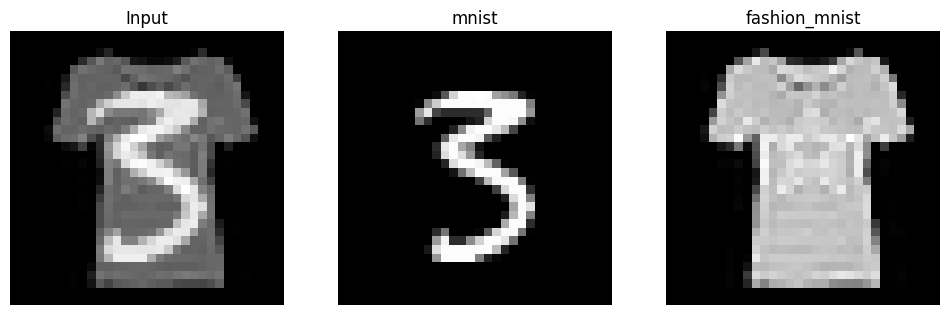

In [ ]:
onegen = datagenerator(mnist_x_test,fashion_mnist_x_test,1)
x,(y1,y2)=next(onegen)
show_images(x[0],y1[0],y2[0])

## Architecture
The objective of the task is to reconstruct the 2 original images starting from their overlapping. An encoder-decoder based network is highly advisable for this task; computing a "compressed" representation of the input through the encoder that is then reconstructed by the decoder, giving 2 images in ouput.  
U-Net is an architecture of this kind, a fully convolutional network. We will start by implementing it from scratch from the [original paper's](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) architecture:
<div align="center">
    <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png" width="500px">
</div>

### Encoder
The encoder is a feature extractor; it learns a representation of the image through a sequence of encoder blocks, convolutions and downsampling.  
Each encoder block is a stack of 2 3x3 convolution with stride 1, followed by relu and maxpooling with stride 2 for downsampling purposes. The number of channel is doubled after every encoder block.
### Bottleneck
A stack of convolutions that connects the encoder to the decoder.
### Decoder
The decoder is a sequence of blocks, responsible for reconstructing the 2 images by iteratively upsampling the output of the encoder together with skip connections.  
A decoder block performs a transposed convolution with stride 2 to upsample, followed by a concatenation with the skip connection and 2 3x3 convolutions.
### Skip connections.
The skip connections helps the decoder in the reconstruction of the images and allow the gradient to flow.
### Batch normalization.
Despite the original implementation was not considering batch normalization layers after convolutions, modern implementation of the U-NET do include it. We will make use of it between convolutions and activations.
### Output.
Since the output of the network are 2 images, we will apply to the last decoder block 2 parallel 1x1 convolutions in order to output the images with the correct channel dimension (32,32,1). The activation function used here is a sigmoid, since we want each output pixel to be a number between 0 and 1, corresponding to its brightness.

In [ ]:
def unet_baseline():

    def convolutional_block(x, filters, kernel_size=(3, 3), padding="same"):
        x = Conv2D(filters, kernel_size, padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def encoder_block(x, filters, pool_size=(2, 2)):
        x = convolutional_block(x, filters)
        p = MaxPooling2D(pool_size)(x)
        return x, p

    def decoder_block(x, skip, filters, kernel_size=(2, 2), strides=(2, 2), padding="same"):
        x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
        x = concatenate([x, skip])
        x = convolutional_block(x, filters)
        return x

    inputs = layers.Input(shape=(32,32,1))

    # encoder
    s1, p1 = encoder_block(inputs, filters=64)
    s2, p2 = encoder_block(p1, filters=128)
    s3, p3 = encoder_block(p2, filters=256)
    s4, p4 = encoder_block(p3, filters=512)

    # bottleneck
    b1 = convolutional_block(p4, filters=1024)

    # decoder
    d1 = decoder_block(b1, skip=s4, filters=512)
    d2 = decoder_block(d1, skip=s3, filters=256)
    d3 = decoder_block(d2, skip=s2, filters=128)
    d4 = decoder_block(d3, skip=s1, filters=64)

    # output layers
    output_img1 = Conv2D(1, (1, 1), activation="sigmoid", name="output_img1")(d4)
    output_img2 = Conv2D(1, (1, 1), activation="sigmoid", name="output_img2")(d4)

    model = Model(inputs, [output_img1, output_img2])
    return model

## Training
The dataset is pretty simple and our architecture should be complex enough to be able to reconstruct very precisely the input images. For what we said earlier, overfitting is hardly possible; no real need of regularization techniques like L1/L2 norm or dropout layers.  
What we focused on for the training recipe is, after a bit of hyperparameter tuning:
- Adam optimizer, with learning rate $= 10^{-3}$
- learning rate scheduler (ReducedOnPlateau scheduler), the learning rate is halved whenever we reach a plateau in the validation loss, with 5 epochs patience. It was found to be the fundamental component to avoid skipping and exploring promising local minimas of our loss function;
- early stopping, we will stop training when the validation loss is not increasing for 10 epochs, with 100 epochs at most.
- steps per epoch = 2000, we fix the number of batches to process each epoch since the dataset is provided by a generator.
- batch size = 32 the number of images used to update the gradient in the optimization method.

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)
optimizer = Adam(learning_rate=1e-3)
early_stopping =  EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
max_epochs = 100
steps_per_epoch = 2000

batch_size = 32
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batch_size)
val_generator = datagenerator(mnist_x_val, fashion_mnist_x_val, batch_size)
test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, 5000)

## Evaluation
The evaluation of the model is done by computing the MSE between the predictions and the ground-truth images. The MSE is computed 10 times on a testset of 5000 images, computing the mean value and the standard deviation. The MSE is also used as the loss function of the task.

In [ ]:
def eval_model(model):
    x, (y1,y2) = next(test_generator)

    pred1,pred2 = model.predict(x)

    pred1 = np.squeeze(pred1)
    pred2 = np.squeeze(pred2)

    return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2) / 2)

# Baseline U-NET
Let's start by instantiating our baseline U-NET architecture.

In [ ]:
unet_model = unet_baseline()
unet_model.compile(optimizer=optimizer, loss='mse')
unet_model.name = 'unet_baseline'
unet_model.summary()

Model: "unet_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 16, 16, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 16, 16, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 128)      │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,054,210 (118.46 MB)

 Trainable params: 31,042,434 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

It is pretty big! 31 millions parameters, with 4 encoder and decoder blocks.

In [ ]:
checkpoint_filepath = 'unet_baseline.weights.h5'

checkpoint = ModelCheckpoint(   # Let's save the best weights during training
                                filepath=checkpoint_filepath,
                                monitor='val_loss',
                                save_best_only=True,
                                save_weights_only=True,
                                mode='min',
                                verbose=0
                            )

history = unet_model.fit(train_generator,
                         validation_data=val_generator,
                         epochs=max_epochs,
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=500,
                         callbacks = [checkpoint, early_stopping, lr_scheduler])

unet_model.load_weights(checkpoint_filepath)

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - loss: 0.0181 - output_img1_loss: 0.0112 - output_img2_loss: 0.0069 - val_loss: 0.0031 - val_output_img1_loss: 0.0014 - val_output_img2_loss: 0.0017 - learning_rate: 0.0010
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - loss: 0.0030 - output_img1_loss: 0.0014 - output_img2_loss: 0.0017 - val_loss: 0.0025 - val_output_img1_loss: 0.0012 - val_output_img2_loss: 0.0013 - learning_rate: 0.0010
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - loss: 0.0023 - output_img1_loss: 0.0011 - output_img2_loss: 0.0013 - val_loss: 0.0019 - val_output_img1_loss: 8.9813e-04 - val_output_img2_loss: 9.7604e-04 - learning_rate: 0.0010
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 0.0020 - output_img1_loss: 9.0021e-04 - output_img2_loss: 0.0011 - val_loss: 0.0093 - val_output_img1_loss: 0.0025 - val_output_img2_loss: 0.0068 - learning_rate: 0.0010
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss:

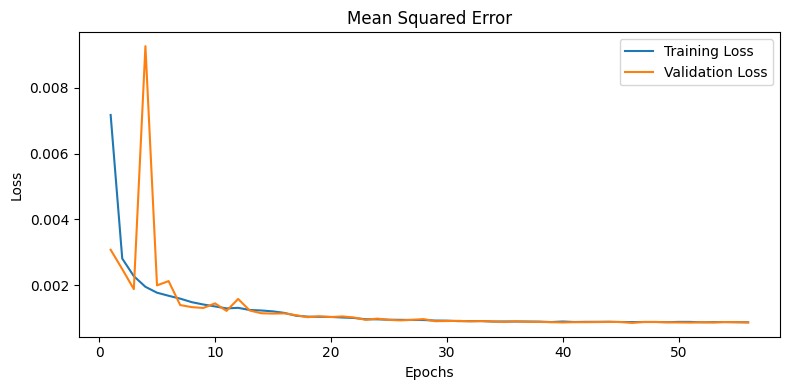

In [ ]:
def plot_training(history):
    """Plots the training history."""
    plt.figure(figsize=(8, 4))

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Mean Squared Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)

We reached a very low MSE value in both training and validation set. As we can see from the training curves, overfitting hasn't happened.  
Let's evaluate the model on the test set!

In [ ]:
def eval_model_n_times(model, n=10):
    eval_results = []

    for i in range(n):
      eval_results.append(eval_model(model))
    print("mse = ", np.mean(eval_results))
    print("standard deviation = ", np.std(eval_results))

eval_model_n_times(unet_model, n=10)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
mse =  0.000657057590674402
standard deviation =  1.04188420481508e-05


Our baseline U-NET performs very good also in the test set, with an $MSE \approx 6.57 \times 10^{-4}$.  
Let's plot some predictions to compare them with the ground-truth images.

In [ ]:
def plot_predictions(model, n):
  test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,n)
  eval_samples_x, (eval_samples_y1, eval_samples_y2) = next(test_generator)
  y1,y2 = model.predict(eval_samples_x)
  fig, ax = plt.subplots(n,3,figsize=(2*n,n*2))
  for i in range(n):
    ax[i,0].imshow(eval_samples_x[i],cmap='gray')
    ax[i,0].title.set_text('Input')
    ax[i,0].axis('off')
    ax[i,1].imshow(np.concatenate((eval_samples_y1[i],np.squeeze(y1[i])), axis=1) , cmap='gray')
    ax[i,1].title.set_text('mnist vs predicted')
    ax[i,1].axis('off')
    ax[i,2].imshow(np.concatenate((eval_samples_y2[i],np.squeeze(y2[i])), axis=1) ,cmap='gray')
    ax[i,2].title.set_text('fashion mnist vs predicted')
    ax[i,2].axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


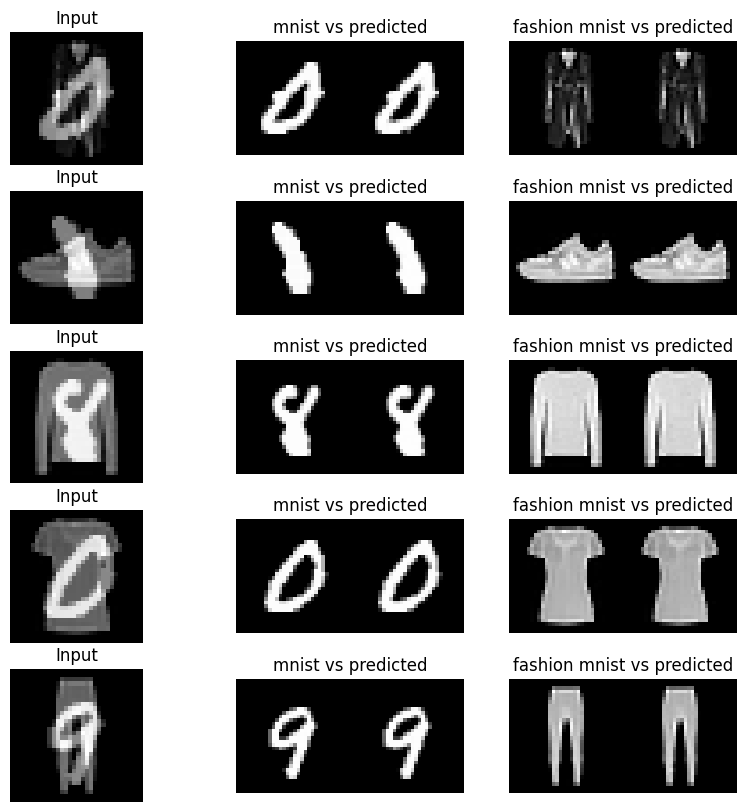

In [ ]:
def plot_predictions(model, n):
  test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,n)
  eval_samples_x, (eval_samples_y1, eval_samples_y2) = next(test_generator)
  y1,y2 = model.predict(eval_samples_x)
  fig, ax = plt.subplots(n,3,figsize=(2*n,n*2))
  for i in range(n):
    ax[i,0].imshow(eval_samples_x[i],cmap='gray')
    ax[i,0].title.set_text('Input')
    ax[i,0].axis('off')
    ax[i,1].imshow(np.concatenate((eval_samples_y1[i],np.squeeze(y1[i])), axis=1) , cmap='gray')
    ax[i,1].title.set_text('mnist vs predicted')
    ax[i,1].axis('off')
    ax[i,2].imshow(np.concatenate((eval_samples_y2[i],np.squeeze(y2[i])), axis=1) ,cmap='gray')
    ax[i,2].title.set_text('fashion mnist vs predicted')
    ax[i,2].axis('off')
  plt.show()

plot_predictions(unet_model, 5)

We can appreciate the quality of the reconstruction of our model, which performs very good according to a human eye. But our architecture has a very big number of parameters...   
Can we do the same (or even better) with a "simpler" architecture?

# U-NET 3 encoder-decoder blocks
Let's reduce the number of encoder and decoder blocks, bringing them to 3. The channel dimension of the bottleneck convolution is lowered accordingly.

In [ ]:
def unet_reduced_1():

    def convolutional_block(x, filters, kernel_size=(3, 3), padding="same"):
        x = Conv2D(filters, kernel_size, padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def encoder_block(x, filters, pool_size=(2, 2)):
        x = convolutional_block(x, filters)
        p = MaxPooling2D(pool_size)(x)
        return x, p

    def decoder_block(x, skip, filters, kernel_size=(2, 2), strides=(2, 2), padding="same"):
        x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
        x = concatenate([x, skip])
        x = convolutional_block(x, filters)
        return x

    inputs = layers.Input(shape=(32,32,1))

    # encoder
    s1, p1 = encoder_block(inputs, filters=64)
    s2, p2 = encoder_block(p1, filters=128)
    s3, p3 = encoder_block(p2, filters=256)

    # bottleneck
    b1 = convolutional_block(p3, filters=512)

    # decoder
    d1 = decoder_block(b1, skip=s3, filters=256)
    d2 = decoder_block(d1, skip=s2, filters=128)
    d3 = decoder_block(d2, skip=s1, filters=64)

    # output layers
    output_img1 = Conv2D(1, (1, 1), activation="sigmoid", name="output_img1")(d3)
    output_img2 = Conv2D(1, (1, 1), activation="sigmoid", name="output_img2")(d3)

    model = Model(inputs, [output_img1, output_img2])
    return model

In [ ]:
unet_reduced1 = unet_reduced_1()
unet_reduced1.compile(optimizer=optimizer, loss='mse')
unet_reduced1.name = 'unet_reduced_1'
unet_reduced1.summary()

Model: "unet_reduced_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 16, 16, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 16, 16, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 128)      │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 7,707,522 (29.40 MB)

 Trainable params: 7,701,890 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

By using only 3 encoder-decoder blocks we reduced the number of parameters by roughly 4 times, bringing them to 7.7 millions.  
Will it perform as good as the baseline?

In [ ]:
checkpoint_filepath = 'unet_reduced_1.weights.h5'

checkpoint = ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                monitor='val_loss',
                                save_best_only=True,
                                save_weights_only=True,
                                mode='min',
                                verbose=0
                            )

history = unet_reduced1.fit(train_generator,
                            validation_data=val_generator,
                            epochs=max_epochs,
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=500,
                            callbacks = [checkpoint, early_stopping, lr_scheduler])

unet_reduced1.load_weights(checkpoint_filepath)

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0150 - output_img1_loss: 0.0078 - output_img2_loss: 0.0072 - val_loss: 0.0032 - val_output_img1_loss: 0.0013 - val_output_img2_loss: 0.0019 - learning_rate: 0.0010
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0028 - output_img1_loss: 0.0013 - output_img2_loss: 0.0016 - val_loss: 0.0022 - val_output_img1_loss: 0.0010 - val_output_img2_loss: 0.0012 - learning_rate: 0.0010
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0023 - output_img1_loss: 0.0010 - output_img2_loss: 0.0012 - val_loss: 0.0022 - val_output_img1_loss: 9.5735e-04 - val_output_img2_loss: 0.0012 - learning_rate: 0.0010
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0020 - output_img1_loss: 8.9225e-04 - output_img2_loss: 0.0011 - val_loss: 0.0016 - val_output_img1_loss: 7.8716e-04 - val_output_img2_loss: 8.5348e-04 - learning_rate: 0.0010
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - l

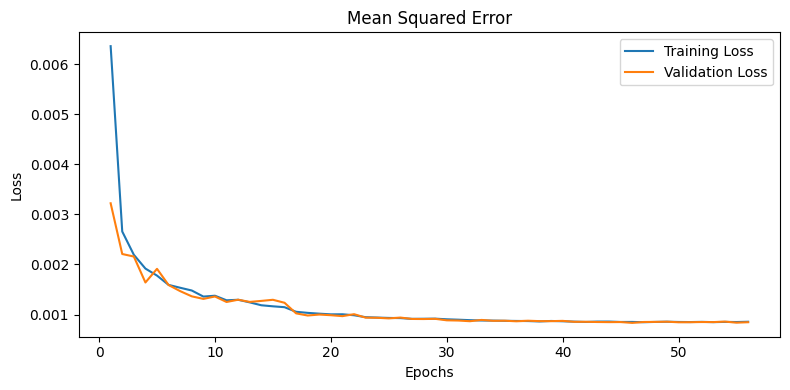

In [ ]:
plot_training(history)

The training and validation losses are comparable to the baseline's ones, and again our model didn't overfit the training data.

In [ ]:
eval_model_n_times(unet_reduced1, n=10)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mse =  0.0006338055103406856
standard deviation =  9.841039097578757e-06


The MSE on the testset slightly improved with respect to our baseline, and with way less parameters, setting it to $MSE \approx 6.33 \times 10^{-4}$. Stochasticity might play a role, but it is definetly a good news since we use less parameters and flops.  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


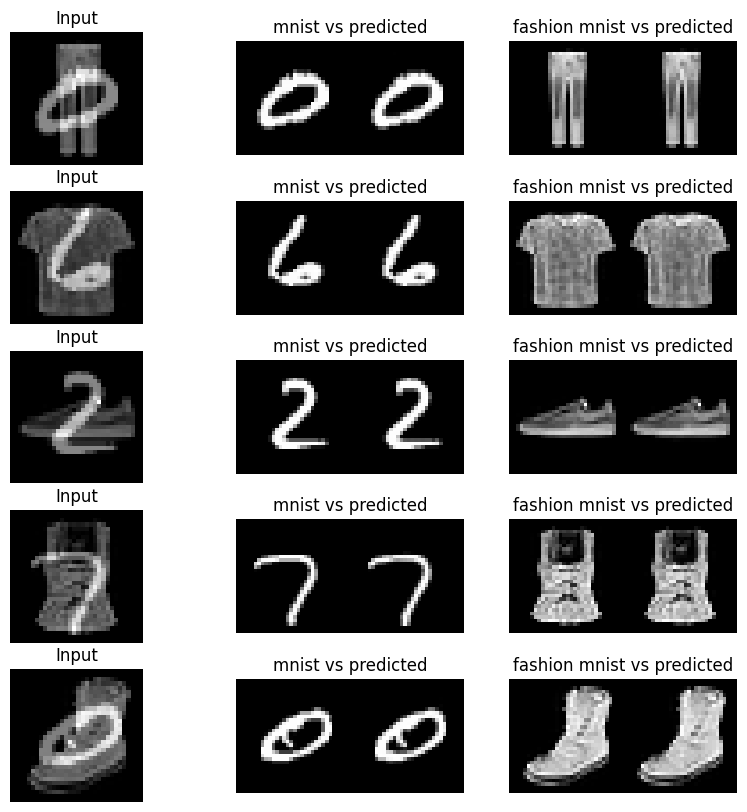

In [ ]:
plot_predictions(unet_reduced1, 5)

Also the plotted prediction show the output of our model, which is pretty good!

 Can we reduce the number of blocks even more?

# U-NET 2 encoder-decoder blocks
Let's lower the number of encoder and decoder blocks to 2, again by changing the number of channels in the bottleneck accordingly.

In [ ]:
def unet_reduced_2():

    def convolutional_block(x, filters, kernel_size=(3, 3), padding="same"):
        x = Conv2D(filters, kernel_size, padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def encoder_block(x, filters, pool_size=(2, 2)):
        x = convolutional_block(x, filters)
        p = MaxPooling2D(pool_size)(x)
        return x, p

    def decoder_block(x, skip, filters, kernel_size=(2, 2), strides=(2, 2), padding="same"):
        x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
        x = concatenate([x, skip])
        x = convolutional_block(x, filters)
        return x

    inputs = layers.Input(shape=(32,32,1))

    # encoder
    s1, p1 = encoder_block(inputs, filters=64)
    s2, p2 = encoder_block(p1, filters=128)

    # bottleneck
    b1 = convolutional_block(p2, filters=256)

    # decoder
    d1 = decoder_block(b1, skip=s2, filters=128)
    d2 = decoder_block(d1, skip=s1, filters=64)

    # output layers
    output_img1 = Conv2D(1, (1, 1), activation="sigmoid", name="output_img1")(d2)
    output_img2 = Conv2D(1, (1, 1), activation="sigmoid", name="output_img2")(d2)

    model = Model(inputs, [output_img1, output_img2])
    return model

In [ ]:
unet_reduced2 = unet_reduced_2()
unet_reduced2.compile(optimizer=optimizer, loss='mse')
unet_reduced2.name = 'unet_reduced_2'
unet_reduced2.summary()

Model: "unet_reduced_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 16, 16, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 16, 16, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 128)      │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 1,866,882 (7.12 MB)

 Trainable params: 1,864,322 (7.11 MB)

 Non-trainable params: 2,560 (10.00 KB)

The U-NET with 2 encoder-decoder blocks has 17 times less parameters than the baseline, with 1.8 millions. Let's try it out!

In [ ]:
checkpoint_filepath = 'unet_reduced_2.weights.h5'

checkpoint = ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                monitor='val_loss',
                                save_best_only=True,
                                save_weights_only=True,
                                mode='min',
                                verbose=0
                            )

history = unet_reduced2.fit(train_generator,
                            validation_data=val_generator,
                            epochs=max_epochs,
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=500,
                            callbacks = [checkpoint, early_stopping, lr_scheduler])

unet_reduced2.load_weights(checkpoint_filepath)

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 60s 23ms/step - loss: 0.0195 - output_img1_loss: 0.0087 - output_img2_loss: 0.0108 - val_loss: 0.0037 - val_output_img1_loss: 0.0016 - val_output_img2_loss: 0.0021 - learning_rate: 0.0010
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 45s 22ms/step - loss: 0.0031 - output_img1_loss: 0.0014 - output_img2_loss: 0.0017 - val_loss: 0.0030 - val_output_img1_loss: 0.0012 - val_output_img2_loss: 0.0018 - learning_rate: 0.0010
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - loss: 0.0024 - output_img1_loss: 0.0011 - output_img2_loss: 0.0013 - val_loss: 0.0022 - val_output_img1_loss: 9.6012e-04 - val_output_img2_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - loss: 0.0021 - output_img1_loss: 9.4617e-04 - output_img2_loss: 0.0011 - val_loss: 0.0018 - val_output_img1_loss: 8.3699e-04 - val_output_img2_loss: 9.6706e-04 - learning_rate: 0.0010
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - l

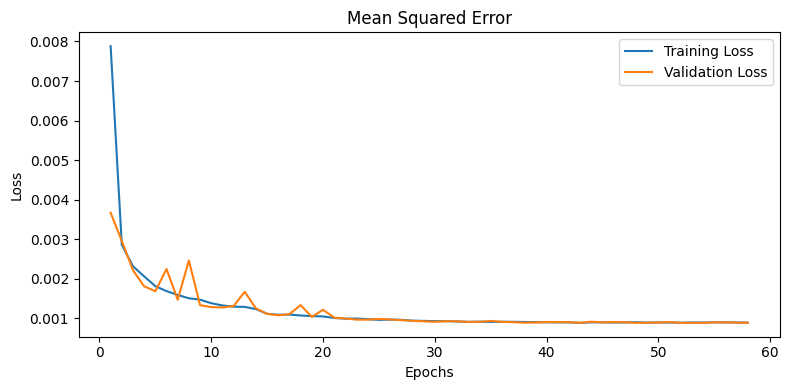

In [ ]:
plot_training(history)

Again, the losses are comparable to the previous 2 networks.

In [ ]:
eval_model_n_times(unet_reduced2, n=10)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
mse =  0.0006699277602235174
standard deviation =  5.831275257532469e-06


There is a very low difference in the MSE with respect to the other 2 models, the performances here are slightly worse but much more efficient to train compared to the baseline. $MSE \approx 6.69 \times 10^{-4}$.
Are also the visual prediction as good as before?

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


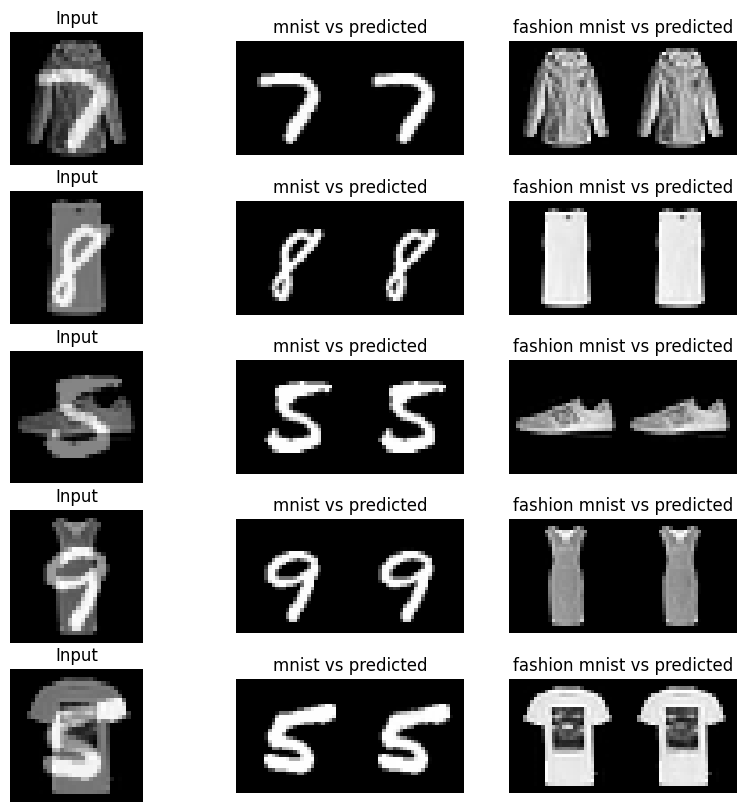

In [ ]:
plot_predictions(unet_reduced2, 5)

A human can't spot the difference in terms of quality of the results, so this network performs very good!  
Can we simplify even more the network?

# U-NET 2 encoder-decoder blocks with lighter convolutions
Here, convolutional blocks are not 2 stacks of 3x3 convolution, but they exploit:
- 1x1 convolution;  
- 3x3 convolution;
- 1x1 convolution.  

In this way, we are able to go deeper (3 convolutions instead of 2) but with overall less parameters.  
The idea was taken from [bottleneck residual blocks](https://paperswithcode.com/method/bottleneck-residual-block) (but bottlenecks are not effective in this architecture, so the number of channels is preserved).

In [ ]:
def unet_reduced_3():

    def convolutional_block(x, filters, kernel_size=(3, 3), padding="same"):
        x = Conv2D(filters, (1,1), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, (1,1), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def encoder_block(x, filters, pool_size=(2, 2)):
        x = convolutional_block(x, filters)
        p = MaxPooling2D(pool_size)(x)
        return x, p

    def decoder_block(x, skip, filters, kernel_size=(2, 2), strides=(2, 2), padding="same"):
        x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
        x = concatenate([x, skip])
        x = convolutional_block(x, filters)
        return x

    inputs = layers.Input(shape=(32,32,1))

    # encoder
    s1, p1 = encoder_block(inputs, filters=64)
    s2, p2 = encoder_block(p1, filters=128)

    # bottleneck
    b1 = convolutional_block(p2, filters=256)

    # decoder
    d1 = decoder_block(b1, skip=s2, filters=128)
    d2 = decoder_block(d1, skip=s1, filters=64)

    # output layers
    output_img1 = Conv2D(1, (1, 1), activation="sigmoid", name="output_img1")(d2)
    output_img2 = Conv2D(1, (1, 1), activation="sigmoid", name="output_img2")(d2)

    model = Model(inputs, [output_img1, output_img2])
    return model

In [ ]:
unet_reduced3 = unet_reduced_3()
unet_reduced3.compile(optimizer=optimizer, loss='mse')
unet_reduced3.name = 'unet_reduced_3'
unet_reduced3.summary()

Model: "unet_reduced_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │          4,160 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │          8,320 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 16, 16, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 16, 16, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 1,320,706 (5.04 MB)

 Trainable params: 1,316,866 (5.02 MB)

 Non-trainable params: 3,840 (15.00 KB)

We reduced the number of parameters by 23 times with respect to the baseline. Will the model still perform as good as it?

In [ ]:
checkpoint_filepath = 'unet_reduced_3.weights.h5'

checkpoint = ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                monitor='val_loss',
                                save_best_only=True,
                                save_weights_only=True,
                                mode='min',
                                verbose=0
                            )

history = unet_reduced3.fit(train_generator,
                            validation_data=val_generator,
                            epochs=max_epochs,
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=500,
                            callbacks = [checkpoint, early_stopping, lr_scheduler])

unet_reduced3.load_weights(checkpoint_filepath)

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 61s 21ms/step - loss: 0.0171 - output_img1_loss: 0.0072 - output_img2_loss: 0.0099 - val_loss: 0.0030 - val_output_img1_loss: 0.0014 - val_output_img2_loss: 0.0016 - learning_rate: 0.0010
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0031 - output_img1_loss: 0.0014 - output_img2_loss: 0.0017 - val_loss: 0.0025 - val_output_img1_loss: 0.0011 - val_output_img2_loss: 0.0014 - learning_rate: 0.0010
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0024 - output_img1_loss: 0.0011 - output_img2_loss: 0.0013 - val_loss: 0.0041 - val_output_img1_loss: 0.0020 - val_output_img2_loss: 0.0022 - learning_rate: 0.0010
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0022 - output_img1_loss: 0.0010 - output_img2_loss: 0.0011 - val_loss: 0.0017 - val_output_img1_loss: 8.0059e-04 - val_output_img2_loss: 9.3375e-04 - learning_rate: 0.0010
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0

Training and validation losses are this time slightly higher, but still in the same order of magnitude.

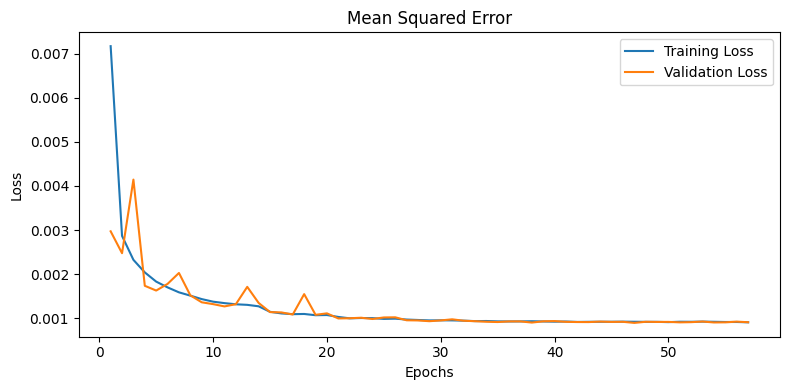

In [ ]:
plot_training(history)

In [ ]:
eval_model_n_times(unet_reduced3, n=10)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
mse =  0.000680243968825025
standard deviation =  9.094705132278545e-06


The MSE on the testset is still very good: $MSE \approx 6.80 \times 10^{-4}$.  
The relative difference (in %) between baseline's MSE and this one is:  
$rel_{diff} = \frac{MSE_{baseline}-MSE_{reduced}}{MSE_{baseline}} \times 100 = 3.5\%$  
which is quite low considering that it has 23 times number of parameters less!

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


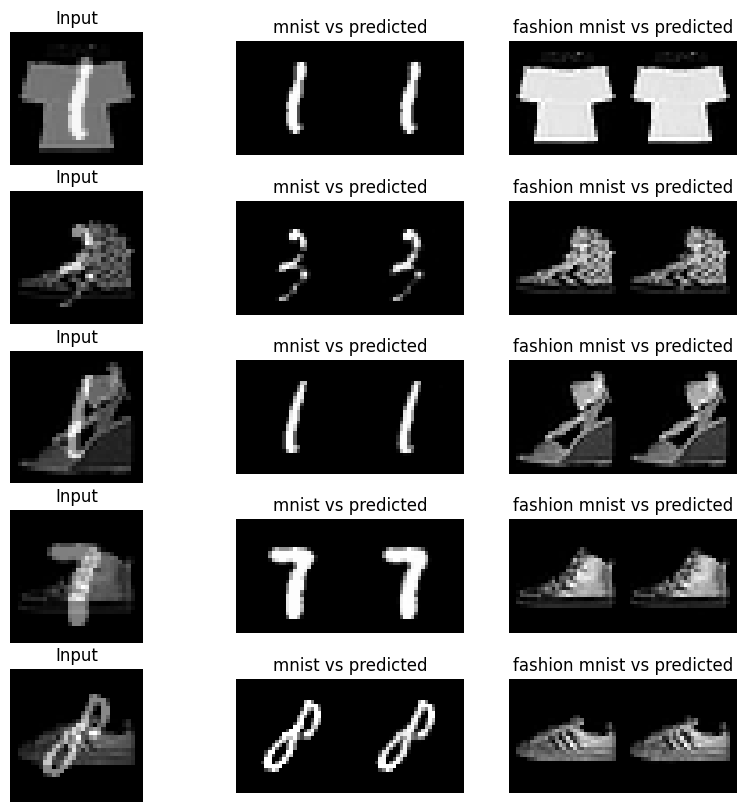

In [ ]:
plot_predictions(unet_reduced3, 5)

The visual prediction are again very good, comparable with the other models.
## Conclusions.
The approach used to tackle the task was to start from a known baseline and iterively simplify the architecture in order to boost the performances and speed up the training, with a simpler network.  
The starting U-NET has 31 millions parameter, with 4 encoder-decoder blocks and reached an $MSE = 6.57 \times 10^{-4}$.  
The lightest U-NET has 1.3 millions parameter, with 2 encoder-decoder blocks and lighter convolutions, reached an $MSE = 6.80 \times 10^{-4}$. Having 23 times less parameters and being 4 times faster in training time, we can say that it is an efficient implementation for the task at hand, especially with low resources at our disposal.  
The best architecture turned out to be the 3 encoder-decoder blocks U-NET, with an $MSE = 6.33 \times 10^{-4}$ and 7.5 millions parameter.  
It is worth to note that hyperparameter tuning is crucial for a fixed architecture, and this process has not been shown but only the final training recipe.
Overall, we can conclude:
- The dataset is very simple yet diverse; our model didn't overfit and we reached almost the same results in training and validation set. For this reason, we could have avoided using a validation set and we could have trained the network with the whole dataset, and used the training loss as a flag for early stopping and learning rate decrease.
- The U-NET is a very effective architecture for this task; we can reduce its complexity by reducing the number of encoder-decoder blocks and/or the convolution to perform inside each convolutional block.  
- Among the tested network, the relative difference between the various MSEs is very low: for this reason the 2 encoder-decoder with lighter convolutions U-NET it is a very good tradeoff between number of parameters, required flops and quality of the results if we have low resources at our disposal.
- Learning rate scheduler helped exploring better minima of our loss function and allowed us to improve the overall results. More advanced scheduler could have helped in improving the overall performance.  

# End.